<a href="https://colab.research.google.com/github/deea-c/thesis_absa/blob/main/Stratified_k_fold.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
%cd /content/drive/MyDrive/Colab Notebooks/code
!pwd 

/content/drive/MyDrive/Colab Notebooks/code
/content/drive/MyDrive/Colab Notebooks/code


In [ ]:
# #To install
!pip install evaluate
!pip install seqeval (need to install this) 
!pip install transformers
!pip install seqeval
!pip install --upgrade accelerate

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.4/81.4 kB 3.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 474.6/474.6 kB 17.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.5/110.5 kB 16.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.5/212.5 kB 29.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.3/134.3 kB 12.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 28.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 52.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.5/114.5 kB 15.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 25.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 149.6/149.6 kB 19.6 MB/s eta 0:00:00
/bin/bash: -c: line 0: syntax error near unexpected token `('
/bin/bash: -c: line 0: `pip inst

In [ ]:
#Packages
from help_functions import get_annotations_as_dict, align_tokens_and_annotations_bio, compute_metrics
from help_functions import metric
from help_functions import TraingDataset, LabelSet, TrainingExample, label_list, label_set
import pandas as pd 
import numpy as np
from transformers import AutoTokenizer,EarlyStoppingCallback
from transformers import AutoModelForTokenClassification, TrainingArguments, Trainer
from transformers import DataCollatorForTokenClassification
from sklearn.model_selection import train_test_split
from seqeval.metrics import classification_report
import evaluate
import transformers
from sklearn.model_selection import RepeatedKFold, RepeatedStratifiedKFold

np.random.seed(11)


In [ ]:
# #### Load data
language = "EN_BackTranslation_aug_NegNeu" #"dutch" #"English + French"
dutch_test_df = get_annotations_as_dict( pd.read_pickle("../pickles/" + "test_"+"dutch" + ".pkl"))

# df = get_annotations_as_dict( pd.read_pickle("../pickles/" + "train_"+language +".pkl"))
# test_df = get_annotations_as_dict( pd.read_pickle("../pickles/" + "test_"+language + ".pkl"))

In [ ]:
# # #Train & Test data read with multile datasets
# df1 = pd.read_pickle("../pickles/" + "train_"+"English" +".pkl")
# df2 = pd.read_pickle("../pickles/" + "train_"+"French" +".pkl")
# df = pd.concat([df1, df2], axis=0)
# df.reset_index(drop=True, inplace=True)
# df = get_annotations_as_dict(df)

# tdf1 = pd.read_pickle("../pickles/" + "test_"+"English" +".pkl")
# tdf2 = pd.read_pickle("../pickles/" + "test_"+"French" +".pkl")
# test_df =  pd.concat([tdf1, tdf2], axis=0)
# test_df.reset_index(drop=True, inplace=True)
# test_df = get_annotations_as_dict(test_df)

In [ ]:
#with Data augmentation
df1 = pd.read_pickle("../pickles/" + "train_"+"English" +".pkl")
df2 = pd.read_pickle("../pickles/" + "BackTranslation_aug_NegNeu" +".pkl")
df = pd.concat([df1, df2], axis=0)
df.reset_index(drop=True, inplace=True)
df = get_annotations_as_dict(df)
print(df1.shape, df2.shape, df.shape)
test_df = get_annotations_as_dict( pd.read_pickle("../pickles/" + "test_"+"English" + ".pkl"))

(2507, 8) (483, 7) (2088, 4)


In [ ]:
models = [
    {'name': 'bert-base-multilingual-cased', 'training_args': { 'num_train_epochs': 3}},
    {'name': 'xlm-roberta-base', 'training_args': {'num_train_epochs': 5}}
    # {'name': 'GroNLP/bert-base-dutch-cased', 'training_args': { 'num_train_epochs': 5}}
    ]


In [ ]:

# Perform k-fold cross-validation 
evaluation_metrics = ['eval_val_precision', 'eval_val_recall', 'eval_val_f1', 'eval_val_accuracy'] 
# Initialize an empty DataFrame to store the evaluation results
results_df = pd.DataFrame(columns=['Model', 'Fold'] +
                          [f'train_{metric}' for metric in evaluation_metrics] +
                          [f'val_{metric}' for metric in evaluation_metrics] +
                          [f'test_{metric}' for metric in evaluation_metrics] +
                          [f'dutch_test_{metric}' for metric in evaluation_metrics])



kfold =  RepeatedStratifiedKFold(n_splits=5, n_repeats=2, random_state=11)
for fold, (train_index, val_index) in enumerate(kfold.split(df['Text'],df['polarities'])):
    print(f"Processing Fold: {fold + 1}")
    train_df = df.iloc[train_index]
    val_df = df.iloc[val_index]
    
    
    for model_info in models:
        model_name = model_info['name']
        num_train_epochs = model_info['training_args']["num_train_epochs"]

        tokenizer = AutoTokenizer.from_pretrained(model_name) # Load a pre-trained tokenizer
        label_set = LabelSet(labels=["positive", "negative", "neutral"])

        train_ds = TraingDataset( data= train_df, tokenizer=tokenizer, label_set=label_set, tokens_per_batch=89)
        val_ds = TraingDataset( data= val_df, tokenizer=tokenizer, label_set=label_set, tokens_per_batch=89)
        test_ds = TraingDataset( data= test_df, tokenizer=tokenizer, label_set=label_set, tokens_per_batch=89)
        dutch_test_ds = TraingDataset( data= dutch_test_df, tokenizer=tokenizer, label_set=label_set, tokens_per_batch=89)
        
        model = AutoModelForTokenClassification.from_pretrained(model_name, num_labels=len(label_set.labels_to_id), label2id = label_set.labels_to_id, id2label =label_set.ids_to_label )
        data_collator = DataCollatorForTokenClassification(tokenizer)
        model_n = model_name.split("/")[-1]
        batch_size = 16
        args = TrainingArguments(
            output_dir = f"kfold/{model_n}-{language}",
            overwrite_output_dir = True,
            logging_dir= f"kfold/{model_n}-{language}/log",
            evaluation_strategy = "epoch",
            logging_strategy= "epoch", 
            learning_rate=2e-5,
            per_device_train_batch_size=batch_size,
            per_device_eval_batch_size=batch_size,
            weight_decay=0.01,
            seed = 11,
            push_to_hub= False,
            num_train_epochs = num_train_epochs
        )
        print(f"Training Model: {model_name}")
        
        trainer = Trainer(
            model,
            args,
            train_dataset= train_ds,
            eval_dataset= val_ds,
            data_collator=data_collator,
            tokenizer=tokenizer,
            compute_metrics=compute_metrics,
            )
        trainer.train()
        results_train = trainer.evaluate(train_ds)
        results_val = trainer.evaluate(val_ds)
        results_test = trainer.evaluate(test_ds)
        results_dutch_test = trainer.evaluate(dutch_test_ds)
        # Store evaluation results

        result_row = {'Model': model_name, 'Fold': fold + 1}
        result_row.update({f'train_{metric}': results_train[metric] for metric in evaluation_metrics})
        result_row.update({f'val_{metric}': results_val[metric] for metric in evaluation_metrics})
        result_row.update({f'test_{metric}': results_test[metric] for metric in evaluation_metrics})
        result_row.update({f'dutch_test_{metric}': results_dutch_test[metric] for metric in evaluation_metrics})
        results_df = results_df.append(result_row, ignore_index=True)

# Save the evaluation results to a CSV 
results_df.to_csv(f'{language}_evaluation_results.csv', index=False)




Processing Fold: 1


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForTokenClassification: ['cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at 

Training Model: bert-base-multilingual-cased


You're using a BertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Epoch,Training Loss,Validation Loss,Val Precision,Val Recall,Val F1,Val Accuracy
1,0.428600,0.269311,0.243636,0.151927,0.187151,0.909271
2,0.239400,0.215835,0.454545,0.487528,0.470460,0.926862
3,0.187100,0.205934,0.476091,0.519274,0.496746,0.931623


Some weights of the model checkpoint at xlm-roberta-base were not used when initializing XLMRobertaForTokenClassification: ['lm_head.layer_norm.weight', 'lm_head.dense.bias', 'lm_head.layer_norm.bias', 'lm_head.decoder.weight', 'lm_head.bias', 'lm_head.dense.weight']
- This IS expected if you are initializing XLMRobertaForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLMRobertaForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of XLMRobertaForTokenClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-st

Training Model: xlm-roberta-base


You're using a XLMRobertaTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Epoch,Training Loss,Validation Loss,Val Precision,Val Recall,Val F1,Val Accuracy
1,0.600100,0.380626,0.051724,0.006803,0.012024,0.889011
2,0.345100,0.258608,0.313808,0.340136,0.326442,0.912942
3,0.246800,0.228453,0.403259,0.448980,0.424893,0.925732
4,0.215700,0.217747,0.425051,0.469388,0.446121,0.923257
5,0.193500,0.218722,0.439689,0.512472,0.473298,0.925320


Processing Fold: 2


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForTokenClassification: ['cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at 

Training Model: bert-base-multilingual-cased


You're using a BertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Epoch,Training Loss,Validation Loss,Val Precision,Val Recall,Val F1,Val Accuracy
1,0.388900,0.313521,0.278169,0.176339,0.215847,0.900318
2,0.223000,0.240982,0.434685,0.430804,0.432735,0.923161
3,0.170100,0.234967,0.426339,0.426339,0.426339,0.927071


Some weights of the model checkpoint at xlm-roberta-base were not used when initializing XLMRobertaForTokenClassification: ['lm_head.layer_norm.weight', 'lm_head.dense.bias', 'lm_head.layer_norm.bias', 'lm_head.decoder.weight', 'lm_head.bias', 'lm_head.dense.weight']
- This IS expected if you are initializing XLMRobertaForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLMRobertaForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of XLMRobertaForTokenClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-st

Training Model: xlm-roberta-base


You're using a XLMRobertaTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Epoch,Training Loss,Validation Loss,Val Precision,Val Recall,Val F1,Val Accuracy
1,0.524300,0.343587,0.244526,0.299107,0.269076,0.888085
2,0.273100,0.291255,0.296073,0.437500,0.353153,0.895572
3,0.220500,0.246253,0.373239,0.354911,0.363844,0.914478
4,0.186700,0.235438,0.391919,0.433036,0.411453,0.921330
5,0.169600,0.237988,0.416016,0.475446,0.443750,0.918792


Processing Fold: 3


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForTokenClassification: ['cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at 

Training Model: bert-base-multilingual-cased


You're using a BertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Epoch,Training Loss,Validation Loss,Val Precision,Val Recall,Val F1,Val Accuracy
1,0.411200,0.261780,0.338384,0.301802,0.319048,0.908771
2,0.236000,0.242943,0.363029,0.367117,0.365062,0.913420
3,0.188900,0.251306,0.384306,0.430180,0.405951,0.914551


Some weights of the model checkpoint at xlm-roberta-base were not used when initializing XLMRobertaForTokenClassification: ['lm_head.layer_norm.weight', 'lm_head.dense.bias', 'lm_head.layer_norm.bias', 'lm_head.decoder.weight', 'lm_head.bias', 'lm_head.dense.weight']
- This IS expected if you are initializing XLMRobertaForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLMRobertaForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of XLMRobertaForTokenClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-st

Training Model: xlm-roberta-base


You're using a XLMRobertaTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Epoch,Training Loss,Validation Loss,Val Precision,Val Recall,Val F1,Val Accuracy
1,0.587600,0.439303,0.211982,0.103604,0.139183,0.881389
2,0.363700,0.307853,0.261333,0.220721,0.239316,0.898947
3,0.276400,0.271599,0.314286,0.371622,0.340557,0.904149
4,0.239500,0.272294,0.332700,0.394144,0.360825,0.906750
5,0.217600,0.259332,0.351406,0.394144,0.371550,0.911952


Processing Fold: 4


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForTokenClassification: ['cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at 

Training Model: bert-base-multilingual-cased


You're using a BertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Epoch,Training Loss,Validation Loss,Val Precision,Val Recall,Val F1,Val Accuracy
1,0.409700,0.226115,0.298000,0.354762,0.323913,0.916313
2,0.231800,0.195050,0.370213,0.414286,0.391011,0.925597
3,0.188400,0.194996,0.411017,0.461905,0.434978,0.929576


Some weights of the model checkpoint at xlm-roberta-base were not used when initializing XLMRobertaForTokenClassification: ['lm_head.layer_norm.weight', 'lm_head.dense.bias', 'lm_head.layer_norm.bias', 'lm_head.decoder.weight', 'lm_head.bias', 'lm_head.dense.weight']
- This IS expected if you are initializing XLMRobertaForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLMRobertaForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of XLMRobertaForTokenClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-st

Training Model: xlm-roberta-base


You're using a XLMRobertaTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Epoch,Training Loss,Validation Loss,Val Precision,Val Recall,Val F1,Val Accuracy
1,0.533500,0.274023,0.172775,0.078571,0.108020,0.901909
2,0.290400,0.217072,0.332710,0.423810,0.372775,0.917820
3,0.230600,0.203819,0.433925,0.523810,0.474649,0.926536
4,0.198000,0.194020,0.448077,0.554762,0.495745,0.930686
5,0.176600,0.185042,0.484000,0.576190,0.526087,0.934698


Processing Fold: 5


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForTokenClassification: ['cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at 

Training Model: bert-base-multilingual-cased


You're using a BertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Epoch,Training Loss,Validation Loss,Val Precision,Val Recall,Val F1,Val Accuracy
1,0.394100,0.272069,0.292906,0.291572,0.292237,0.903623
2,0.226000,0.251593,0.257290,0.341686,0.293542,0.911344
3,0.180600,0.261303,0.352227,0.396355,0.372990,0.916449


Some weights of the model checkpoint at xlm-roberta-base were not used when initializing XLMRobertaForTokenClassification: ['lm_head.layer_norm.weight', 'lm_head.dense.bias', 'lm_head.layer_norm.bias', 'lm_head.decoder.weight', 'lm_head.bias', 'lm_head.dense.weight']
- This IS expected if you are initializing XLMRobertaForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLMRobertaForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of XLMRobertaForTokenClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-st

Training Model: xlm-roberta-base


You're using a XLMRobertaTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Epoch,Training Loss,Validation Loss,Val Precision,Val Recall,Val F1,Val Accuracy
1,0.532000,0.350550,0.217391,0.068337,0.103986,0.884766
2,0.281200,0.279420,0.293729,0.405467,0.340670,0.899219
3,0.223500,0.237945,0.399538,0.394077,0.396789,0.919922
4,0.191100,0.242474,0.392789,0.471526,0.428571,0.919922
5,0.171800,0.240295,0.431290,0.464692,0.447368,0.922917


Processing Fold: 6


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForTokenClassification: ['cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at 

Training Model: bert-base-multilingual-cased


You're using a BertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Epoch,Training Loss,Validation Loss,Val Precision,Val Recall,Val F1,Val Accuracy
1,0.408500,0.248884,0.284382,0.274775,0.279496,0.913640
2,0.240500,0.223155,0.330224,0.398649,0.361224,0.920682
3,0.193000,0.215722,0.380414,0.454955,0.414359,0.927477


Some weights of the model checkpoint at xlm-roberta-base were not used when initializing XLMRobertaForTokenClassification: ['lm_head.layer_norm.weight', 'lm_head.dense.bias', 'lm_head.layer_norm.bias', 'lm_head.decoder.weight', 'lm_head.bias', 'lm_head.dense.weight']
- This IS expected if you are initializing XLMRobertaForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLMRobertaForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of XLMRobertaForTokenClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-st

Training Model: xlm-roberta-base


You're using a XLMRobertaTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Epoch,Training Loss,Validation Loss,Val Precision,Val Recall,Val F1,Val Accuracy
1,0.537300,0.290548,0.234000,0.263514,0.247881,0.898471
2,0.285500,0.228844,0.338600,0.337838,0.338219,0.920062
3,0.223700,0.201844,0.458150,0.468468,0.463252,0.931757
4,0.194800,0.193962,0.469636,0.522523,0.494670,0.935355
5,0.170200,0.200218,0.463320,0.540541,0.498960,0.932914


Processing Fold: 7


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForTokenClassification: ['cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at 

Training Model: bert-base-multilingual-cased


You're using a BertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Epoch,Training Loss,Validation Loss,Val Precision,Val Recall,Val F1,Val Accuracy
1,0.397800,0.261547,0.294840,0.262582,0.277778,0.908147
2,0.220100,0.222494,0.329843,0.413567,0.366990,0.921498
3,0.175800,0.220151,0.400802,0.437637,0.418410,0.924465


Some weights of the model checkpoint at xlm-roberta-base were not used when initializing XLMRobertaForTokenClassification: ['lm_head.layer_norm.weight', 'lm_head.dense.bias', 'lm_head.layer_norm.bias', 'lm_head.decoder.weight', 'lm_head.bias', 'lm_head.dense.weight']
- This IS expected if you are initializing XLMRobertaForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLMRobertaForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of XLMRobertaForTokenClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-st

Training Model: xlm-roberta-base


You're using a XLMRobertaTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Epoch,Training Loss,Validation Loss,Val Precision,Val Recall,Val F1,Val Accuracy
1,0.572800,0.355513,0.114754,0.091904,0.102066,0.883554
2,0.302800,0.277878,0.263027,0.231947,0.246512,0.904737
3,0.241300,0.256799,0.298625,0.332604,0.314700,0.907048
4,0.208400,0.243850,0.317114,0.413567,0.358974,0.911542
5,0.188200,0.239072,0.369231,0.420131,0.393040,0.915137


Processing Fold: 8


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForTokenClassification: ['cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at 

Training Model: bert-base-multilingual-cased


You're using a BertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Epoch,Training Loss,Validation Loss,Val Precision,Val Recall,Val F1,Val Accuracy
1,0.392000,0.237825,0.339713,0.334906,0.337292,0.914253
2,0.219700,0.211479,0.410138,0.419811,0.414918,0.931327
3,0.166600,0.203922,0.455670,0.521226,0.486249,0.934362


Some weights of the model checkpoint at xlm-roberta-base were not used when initializing XLMRobertaForTokenClassification: ['lm_head.layer_norm.weight', 'lm_head.dense.bias', 'lm_head.layer_norm.bias', 'lm_head.decoder.weight', 'lm_head.bias', 'lm_head.dense.weight']
- This IS expected if you are initializing XLMRobertaForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLMRobertaForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of XLMRobertaForTokenClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-st

Training Model: xlm-roberta-base


You're using a XLMRobertaTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Epoch,Training Loss,Validation Loss,Val Precision,Val Recall,Val F1,Val Accuracy
1,0.565100,0.309245,0.240418,0.162736,0.194093,0.905373
2,0.296800,0.257547,0.395954,0.323113,0.355844,0.920064
3,0.235900,0.221282,0.410448,0.389151,0.399516,0.927872
4,0.207400,0.220781,0.385928,0.426887,0.405375,0.921652
5,0.181500,0.215085,0.396341,0.459906,0.425764,0.925093


Processing Fold: 9


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForTokenClassification: ['cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at 

Training Model: bert-base-multilingual-cased


You're using a BertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Epoch,Training Loss,Validation Loss,Val Precision,Val Recall,Val F1,Val Accuracy
1,0.403800,0.279577,0.269663,0.270270,0.269966,0.906862
2,0.228400,0.235731,0.371698,0.443694,0.404517,0.916721
3,0.181100,0.230587,0.396728,0.436937,0.415863,0.920483


Some weights of the model checkpoint at xlm-roberta-base were not used when initializing XLMRobertaForTokenClassification: ['lm_head.layer_norm.weight', 'lm_head.dense.bias', 'lm_head.layer_norm.bias', 'lm_head.decoder.weight', 'lm_head.bias', 'lm_head.dense.weight']
- This IS expected if you are initializing XLMRobertaForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLMRobertaForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of XLMRobertaForTokenClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-st

Training Model: xlm-roberta-base


You're using a XLMRobertaTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Epoch,Training Loss,Validation Loss,Val Precision,Val Recall,Val F1,Val Accuracy
1,0.522300,0.333502,0.219672,0.301802,0.254269,0.891928
2,0.280700,0.236416,0.374449,0.382883,0.378619,0.918745
3,0.221200,0.238444,0.391986,0.506757,0.442043,0.909091
4,0.190300,0.216785,0.420857,0.509009,0.460754,0.922231
5,0.169600,0.217919,0.478000,0.538288,0.506356,0.927997


Processing Fold: 10


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForTokenClassification: ['cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at 

Training Model: bert-base-multilingual-cased


You're using a BertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Epoch,Training Loss,Validation Loss,Val Precision,Val Recall,Val F1,Val Accuracy
1,0.382100,0.279664,0.344130,0.401891,0.370774,0.905443
2,0.213700,0.256303,0.417515,0.484634,0.448578,0.911462
3,0.158800,0.269252,0.411765,0.479905,0.443231,0.915474


Some weights of the model checkpoint at xlm-roberta-base were not used when initializing XLMRobertaForTokenClassification: ['lm_head.layer_norm.weight', 'lm_head.dense.bias', 'lm_head.layer_norm.bias', 'lm_head.decoder.weight', 'lm_head.bias', 'lm_head.dense.weight']
- This IS expected if you are initializing XLMRobertaForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLMRobertaForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of XLMRobertaForTokenClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-st

Training Model: xlm-roberta-base


You're using a XLMRobertaTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Epoch,Training Loss,Validation Loss,Val Precision,Val Recall,Val F1,Val Accuracy
1,0.556600,0.347433,0.245714,0.101655,0.143813,0.886811
2,0.295200,0.282044,0.328889,0.349882,0.339061,0.907746
3,0.230600,0.260482,0.400415,0.456265,0.426519,0.914585
4,0.199400,0.257688,0.414079,0.472813,0.441501,0.913189
5,0.180200,0.260560,0.445652,0.484634,0.464326,0.920726


In [ ]:
results_df

,Model,Fold,train_eval_val_precision,train_eval_val_recall,train_eval_val_f1,train_eval_val_accuracy,val_eval_val_precision,val_eval_val_recall,val_eval_val_f1,val_eval_val_accuracy,test_eval_val_precision,test_eval_val_recall,test_eval_val_f1,test_eval_val_accuracy,dutch_test_eval_val_precision,dutch_test_eval_val_recall,dutch_test_eval_val_f1,dutch_test_eval_val_accuracy
0,bert-base-multilingual-cased,1,0.519200,0.563678,0.540526,0.946461,0.476091,0.519274,0.496746,0.931623,0.430746,0.457929,0.443922,0.918426,0.223762,0.302949,0.257403,0.878996
1,xlm-roberta-base,1,0.466699,0.552256,0.505885,0.937758,0.439689,0.512472,0.473298,0.925320,0.444751,0.521880,0.480239,0.921723,0.205674,0.155496,0.177099,0.902305
2,bert-base-multilingual-cased,2,0.551779,0.595757,0.572925,0.954487,0.426339,0.426339,0.426339,0.927071,0.424051,0.433657,0.428800,0.919674,0.195426,0.252011,0.220141,0.885768
3,xlm-roberta-base,2,0.536327,0.609518,0.570585,0.947636,0.416016,0.475446,0.443750,0.918792,0.470752,0.547812,0.506367,0.920918,0.242588,0.241287,0.241935,0.894366
4,bert-base-multilingual-cased,3,0.461500,0.524600,0.491031,0.946261,0.384306,0.430180,0.405951,0.914551,0.477930,0.508091,0.492549,0.925048,0.189781,0.278820,0.225841,0.868894
5,xlm-roberta-base,3,0.401532,0.419908,0.410515,0.929009,0.351406,0.394144,0.371550,0.911952,0.388179,0.393841,0.390990,0.911259,0.182836,0.131367,0.152886,0.898592
6,bert-base-multilingual-cased,4,0.463158,0.521445,0.490576,0.943692,0.411017,0.461905,0.434978,0.929576,0.434655,0.478964,0.455735,0.917658,0.186090,0.265416,0.218785,0.875222
7,xlm-roberta-base,4,0.501693,0.585214,0.540245,0.943252,0.484000,0.576190,0.526087,0.934698,0.475275,0.560778,0.514498,0.923332,0.264789,0.252011,0.258242,0.902433
8,bert-base-multilingual-cased,5,0.489589,0.523103,0.505792,0.947896,0.352227,0.396355,0.372990,0.916449,0.464169,0.461165,0.462662,0.922169,0.165323,0.219839,0.188723,0.881106
9,xlm-roberta-base,5,0.541466,0.577296,0.558807,0.949915,0.431290,0.464692,0.447368,0.922917,0.456884,0.489465,0.472613,0.924137,0.180328,0.147453,0.162242,0.897951


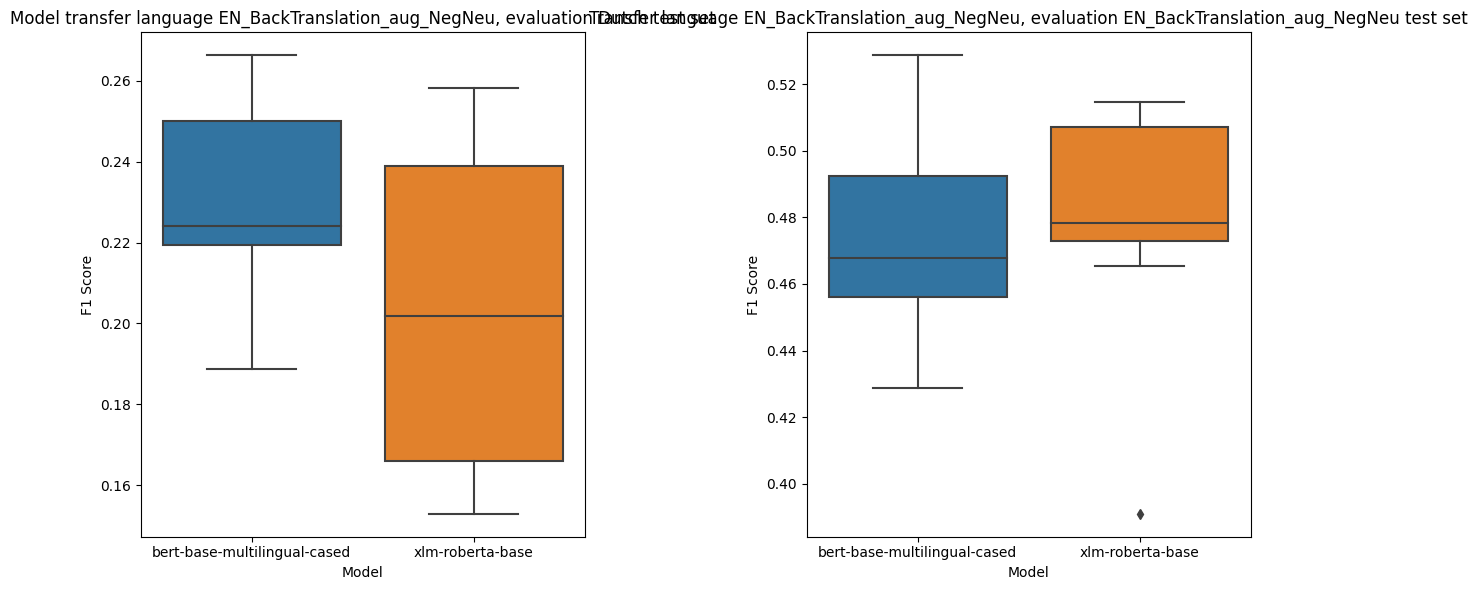

In [ ]:
# Create subplots with two columns
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))

# Boxplot for Dutch test set evaluation
sns.boxplot(x='Model', y='dutch_test_eval_val_f1', data=results_df, ax=axes[0])
axes[0].set_xlabel("Model")
axes[0].set_ylabel('F1 Score')
axes[0].set_title(f'Model transfer language {language}, evaluation Dutch test set')

# Boxplot for language test set evaluation
sns.boxplot(x='Model', y='test_eval_val_f1', data=results_df, ax=axes[1])
axes[1].set_xlabel("Model")
axes[1].set_ylabel('F1 Score')
axes[1].set_title(f'Transfer language {language}, evaluation {language} test set')

# Adjust the spacing between subplots
plt.tight_layout()
plt.subplots_adjust(wspace=0.5)

# Show the plot
plt.show()


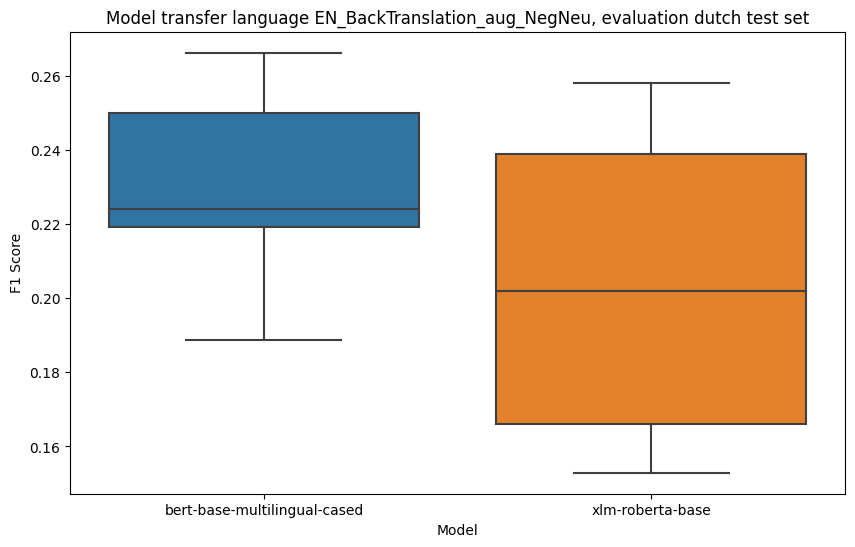

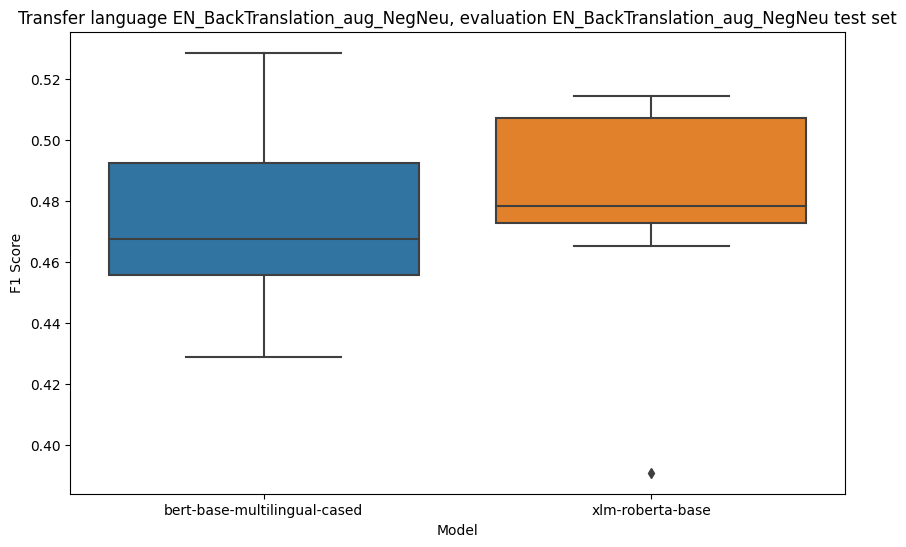

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Create a box and whisker plot for each model
plt.figure(figsize=(10, 6))
sns.boxplot(x='Model', y='dutch_test_eval_val_f1', data=results_df)
plt.xlabel("Model")
plt.ylabel('F1 Score')
plt.title(f'Model transfer language {language}, evaluation dutch test set')

# Show the plot
plt.show()

# Create a box and whisker plot for each model
plt.figure(figsize=(10, 6))
sns.boxplot(x='Model', y='test_eval_val_f1', data=results_df)
plt.xlabel("Model")
plt.ylabel('F1 Score')
plt.title(f'Transfer language {language}, evaluation {language} test set')
# Show the plot
plt.show()
